# Observations
### MLP configurations

> Changes between Configs are in bold

#### Config 1
- Chi2 selected features
- No normalization
- Single layer
- No PCA
- Test Loss 0.392 | Accuracy 0.578
- 70 epochs

#### Config 2
- Chi2 selected features
- __With normalization__
- Single layer
- No PCA
- Test Loss 0.069 | Accuracy 0.703
- 70 epochs

#### Config 3
- __F_classification selected features__
- With normalization
- Single layer
- No PCA
- Test Loss 0.0609 | Accuracy 0.796
- 70 epochs

#### Config 4
- __RandomForestClassifier selected features__
- With normalization
- Single layer
- No PCA
- Test Loss 0.0618 | Accuracy 0.781
- 70 epochs

#### Config 5
- RandomForestClassifier selected features
- With normalization
- Single layer
- __With PCA__
- Test Loss 0.0551 | Accuracy 0.812
- 70 epochs

#### Config 6
- __F_classification selected features__
- With normalization
- Single layer
- With PCA
- Test Loss 0.058 | Accuracy 0.828
- __120 epochs__

#### Config 7
- F_classification selected features
- With normalization
- __Multi Layer:__
  - __nn.Linear(2, 8),__
  - __nn.ReLU(),__
  - __nn.Linear(8, 1)__

- With PCA
- Test Loss 0.053 | Accuracy 0.843
- 120 epochs

#### Config 8
- F_classification selected features
- With normalization
- __Multi Layer:__
  - __nn.Linear(2, 16),__
  - nn.ReLU(),
  - __nn.Linear(16, 1)__

- With PCA
- Test Loss 0.052 | Accuracy 0.875
- 120 epochs

#### Observations
Adding more neurons or layers results in similar or worse performance. \
This means that making the network more complex improves performance until a certain point. \
Then the extra complexity hinders the models abilities.

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("../../Data/cleaned_alzheimer.csv")

selected = {
	"chi2": df[["MMSE", "M/F", "EDUC", "SES"]],
	"f_classif": df[["MMSE", "M/F", "nWBV", "EDUC"]],
	"RandomForestClassifier": df[['MMSE', 'EDUC', 'eTIV', 'nWBV']]
}

# X = selected["chi2"]
X = selected["f_classif"]
# X = selected["RandomForestClassifier"]

# Add Group back
# X["Group"] = df["Group"]
X

,MMSE,M/F,nWBV,EDUC
0,27.0,0,0.696,14
1,30.0,0,0.681,14
2,28.0,1,0.710,18
3,27.0,1,0.718,18
4,28.0,0,0.712,12
...,...,...,...,...
312,28.0,0,0.694,16
313,26.0,0,0.675,16
314,30.0,1,0.801,13
315,30.0,1,0.796,13


In [3]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
X

,MMSE,M/F,nWBV,EDUC
0,-0.067917,-1.146241,-0.909426,-0.210502
1,0.710266,-1.146241,-1.303728,-0.210502
2,0.191477,0.872417,-0.541410,1.158303
3,-0.067917,0.872417,-0.331115,1.158303
4,0.191477,-1.146241,-0.488836,-0.894905
...,...,...,...,...
312,0.191477,-1.146241,-0.961999,0.473900
313,-0.327312,-1.146241,-1.461450,0.473900
314,0.710266,0.872417,1.850694,-0.552704
315,0.710266,0.872417,1.719260,-0.552704


In [4]:
# Reduce demensionality using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X = pd.DataFrame(X_pca, columns=['PC1', 'PC2']).reset_index(drop=True)
X["Group"] = df["Group"]
X

,PC1,PC2,Group
0,-1.137877,0.496305,0
1,-0.888479,0.722173,0
2,0.400792,0.685248,0
3,0.365912,0.597490,0
4,-0.855079,-0.090709,0
...,...,...,...
312,-0.868389,1.134145,1
313,-1.501096,1.104100,1
314,1.846304,-1.021512,0
315,1.765883,-1.000731,0


In [5]:
X.iloc[0].values

array([-1.13787671,  0.49630508,  0.        ])

In [6]:
class AlhemzheimerDataset(Dataset):
	def __init__(self, df):
		self.data = df

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		row = self.data.iloc[idx].values
		# Last value is target
		return torch.tensor(row[:-1], dtype=torch.float32), torch.tensor(row[-1], dtype=torch.float32)

In [7]:
BATCH_SIZE = 8
NUM_WORKERS = 0

# Data loader
dataset = AlhemzheimerDataset(X)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [8]:
next(iter(train_loader))[0].shape

torch.Size([8, 2])

In [9]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

class AlhemzheimerModel(nn.Module):
	def __init__(self):
		super(AlhemzheimerModel, self).__init__()
		
		self.seq1 = nn.Sequential(
			# Fully Connected layers
			nn.Linear(2, 16),
			nn.ReLU(),
			nn.Linear(16, 1),
		)
	
	def forward(self, x):
		x = self.seq1(x)
		return x

torch.manual_seed(43343735689900)
model = AlhemzheimerModel().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [10]:
def train(epoch, train_losses):
	running_loss = 0
	model.train()
	loop = tqdm(train_loader, leave=False, desc=f"Epoch {epoch}")
	for data, target in loop:
		data, target = data.to(device), target.to(device)
		results = model(data).squeeze(1)  # Forward pass
		optimizer.zero_grad()
		loss = loss_fn(results, target)
		loss.backward()  # Back propogation
		optimizer.step()
		loop.set_postfix(loss=loss.item())
		running_loss += loss.item()
	
	train_losses.append(running_loss / len(train_loader))


def test(test_losses):
	model.eval()
	correct = 0
	test_loss = 0
	with torch.inference_mode():
		for data, target in test_loader:
			data, target = data.to(device), target.to(device)
			results = model(data).squeeze(1)
			test_loss += loss_fn(results, target).item()
			preds = (torch.sigmoid(results) > 0.5).float()  # Binary predictions
			correct += (preds == target).sum().item()

	test_loss /= len(test_loader.dataset)
	accuracy = correct / len(test_loader.dataset)
	test_losses.append(test_loss)
	print(f"Test Loss {test_loss} | Accuracy {accuracy}")

In [11]:
train_losses = []
test_losses = []

In [12]:
epochs = 120
for epoch in range(1, epochs + 1):
	train(epoch, train_losses)
	test(test_losses)

Test Loss 0.07814764324575663 | Accuracy 0.578125


Test Loss 0.07704746816307306 | Accuracy 0.578125


Test Loss 0.07604998536407948 | Accuracy 0.640625


Test Loss 0.07501053903251886 | Accuracy 0.65625


Test Loss 0.07404388207942247 | Accuracy 0.6875


Test Loss 0.07304942328482866 | Accuracy 0.71875


Test Loss 0.07207738887518644 | Accuracy 0.734375


Test Loss 0.07113639125600457 | Accuracy 0.75


Test Loss 0.07024788577109575 | Accuracy 0.78125


Test Loss 0.06930326297879219 | Accuracy 0.78125


Test Loss 0.06841017119586468 | Accuracy 0.78125


Test Loss 0.06760726170614362 | Accuracy 0.78125


Test Loss 0.06676807766780257 | Accuracy 0.796875


Test Loss 0.06600474752485752 | Accuracy 0.78125


Test Loss 0.06520706042647362 | Accuracy 0.78125


Test Loss 0.0645128907635808 | Accuracy 0.78125


Test Loss 0.0638120835646987 | Accuracy 0.78125


Test Loss 0.06307048164308071 | Accuracy 0.78125


Test Loss 0.06240197271108627 | Accuracy 0.796875


Test Loss 0.06180214509367943 | Accuracy 0.796875


Test Loss 0.061172335874289274 | Accuracy 0.796875


Test Loss 0.06055752420797944 | Accuracy 0.796875


Test Loss 0.060001444071531296 | Accuracy 0.796875


Test Loss 0.05944782169535756 | Accuracy 0.796875


Test Loss 0.0588774224743247 | Accuracy 0.796875


Test Loss 0.05832816939800978 | Accuracy 0.796875


Test Loss 0.05779852066189051 | Accuracy 0.8125


Test Loss 0.05722980014979839 | Accuracy 0.8125


Test Loss 0.0567601160146296 | Accuracy 0.8125


Test Loss 0.05626304680481553 | Accuracy 0.8125


Test Loss 0.05575558776035905 | Accuracy 0.8125


Test Loss 0.05527052190154791 | Accuracy 0.8125


Test Loss 0.054787174332886934 | Accuracy 0.8125


Test Loss 0.05437294952571392 | Accuracy 0.8125


Test Loss 0.053939353907480836 | Accuracy 0.8125


Test Loss 0.05355833377689123 | Accuracy 0.796875


Test Loss 0.05323424004018307 | Accuracy 0.796875


Test Loss 0.05282937176525593 | Accuracy 0.8125


Test Loss 0.052520385244861245 | Accuracy 0.8125


Test Loss 0.052146483678370714 | Accuracy 0.8125


Test Loss 0.05187423573806882 | Accuracy 0.8125


Test Loss 0.05162016022950411 | Accuracy 0.8125


Test Loss 0.05136113543994725 | Accuracy 0.8125


Test Loss 0.05109668290242553 | Accuracy 0.8125


Test Loss 0.050917427986860275 | Accuracy 0.8125


Test Loss 0.05066417041234672 | Accuracy 0.796875


Test Loss 0.05048158671706915 | Accuracy 0.8125


Test Loss 0.05028048297390342 | Accuracy 0.796875


Test Loss 0.05011100135743618 | Accuracy 0.796875


Test Loss 0.04996286006644368 | Accuracy 0.796875


Test Loss 0.04984134156256914 | Accuracy 0.796875


Test Loss 0.04966644663363695 | Accuracy 0.796875


Test Loss 0.04954702779650688 | Accuracy 0.796875


Test Loss 0.049433823907747865 | Accuracy 0.8125


Test Loss 0.04932071268558502 | Accuracy 0.8125


Test Loss 0.04921355191618204 | Accuracy 0.8125


Test Loss 0.049127299105748534 | Accuracy 0.8125


Test Loss 0.049035185016691685 | Accuracy 0.8125


Test Loss 0.04892429104074836 | Accuracy 0.8125


Test Loss 0.04883566964417696 | Accuracy 0.8125


Test Loss 0.0487436531111598 | Accuracy 0.8125


Test Loss 0.04869080812204629 | Accuracy 0.8125


Test Loss 0.04861593944951892 | Accuracy 0.8125


Test Loss 0.04855435830540955 | Accuracy 0.8125


Test Loss 0.048506109742447734 | Accuracy 0.8125


Test Loss 0.04844723246060312 | Accuracy 0.8125


Test Loss 0.048401834443211555 | Accuracy 0.8125


Test Loss 0.04835616145282984 | Accuracy 0.8125


Test Loss 0.048271363601088524 | Accuracy 0.8125


Test Loss 0.048255265690386295 | Accuracy 0.8125


Test Loss 0.048198553966358304 | Accuracy 0.8125


Test Loss 0.0481644079554826 | Accuracy 0.8125


Test Loss 0.04812516854144633 | Accuracy 0.8125


Test Loss 0.04809841141104698 | Accuracy 0.8125


Test Loss 0.048072030767798424 | Accuracy 0.8125


Test Loss 0.04803653829731047 | Accuracy 0.8125


Test Loss 0.04800541547592729 | Accuracy 0.8125


Test Loss 0.04798007267527282 | Accuracy 0.8125


Test Loss 0.04794488591141999 | Accuracy 0.8125


Test Loss 0.04792199935764074 | Accuracy 0.8125


Test Loss 0.04790890030562878 | Accuracy 0.8125


Test Loss 0.04788005060981959 | Accuracy 0.8125


Test Loss 0.04787229746580124 | Accuracy 0.8125


Test Loss 0.04783366806805134 | Accuracy 0.8125


Test Loss 0.04780412674881518 | Accuracy 0.8125


Test Loss 0.04780060541816056 | Accuracy 0.8125


Test Loss 0.04778400913346559 | Accuracy 0.8125


Test Loss 0.04776535904966295 | Accuracy 0.8125


Test Loss 0.04774595773778856 | Accuracy 0.8125


Test Loss 0.04770805733278394 | Accuracy 0.8125


Test Loss 0.04769143322482705 | Accuracy 0.8125


Test Loss 0.047708532540127635 | Accuracy 0.8125


Test Loss 0.047683327342383564 | Accuracy 0.8125


Test Loss 0.04766650078818202 | Accuracy 0.8125


Test Loss 0.04765921551734209 | Accuracy 0.8125


Test Loss 0.04762418568134308 | Accuracy 0.8125


Test Loss 0.04763565328903496 | Accuracy 0.8125


Test Loss 0.047620196826756 | Accuracy 0.8125


Test Loss 0.047621423844248056 | Accuracy 0.8125


Test Loss 0.0476010472048074 | Accuracy 0.8125


Test Loss 0.04761521879117936 | Accuracy 0.8125


Test Loss 0.047591872746124864 | Accuracy 0.8125


Test Loss 0.04758497257716954 | Accuracy 0.8125


Test Loss 0.04755084519274533 | Accuracy 0.8125


Test Loss 0.04756170744076371 | Accuracy 0.8125


Test Loss 0.04753823298960924 | Accuracy 0.8125


Test Loss 0.047538802959024906 | Accuracy 0.8125


Test Loss 0.04753008671104908 | Accuracy 0.8125


Test Loss 0.047514136880636215 | Accuracy 0.8125


Test Loss 0.04750667104963213 | Accuracy 0.8125


Test Loss 0.047492258716374636 | Accuracy 0.8125


Test Loss 0.04747779294848442 | Accuracy 0.8125


Test Loss 0.047472267178818583 | Accuracy 0.8125


Test Loss 0.0474669320974499 | Accuracy 0.8125


Test Loss 0.0474671320989728 | Accuracy 0.8125


Test Loss 0.04744162387214601 | Accuracy 0.8125


Test Loss 0.04744534147903323 | Accuracy 0.796875


Test Loss 0.047426577657461166 | Accuracy 0.8125


Test Loss 0.04741920833475888 | Accuracy 0.8125


Test Loss 0.047418268863111734 | Accuracy 0.8125


<Axes: >

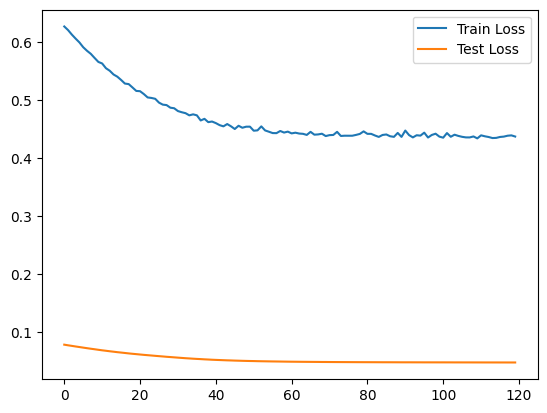

In [13]:
# Plot train loss
sns.lineplot(x=range(len(train_losses)), y=train_losses, label="Train Loss")
sns.lineplot(x=range(len(test_losses)), y=test_losses, label="Test Loss")